In [1]:
import os
import xarray as xr
import numpy as np
import cftime
import glob
import matplotlib.pyplot as plt

In [7]:
from osprey.utils.folders import folders
from osprey.utils.time import get_startleg, get_year
from osprey.utils import run_cdo
from osprey.utils.utils import get_nemo_timestep 
from osprey.means.means import spacemean, timemean
from osprey.actions.reader import elements
from osprey.utils.utils import remove_existing_filelist

In [3]:
expname = "FE00"
var = "tn"
ndim ="3D"
endleg = 11
yearspan = 10
yearleap = 10

In [4]:
dirs = folders(expname)
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1

In [12]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True)
field = pattern.isel(time_counter=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True)
    theta = timeseries[var].isel(time_counter=-1,lat=0,lon=0,zaxis_Reduced=0)
    basis = pattern.isel(time_counter=i)
    field = field + theta*basis
field = field.drop_vars({'time_counter','lon','lat','zaxis_Reduced'})  

In [13]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)
xdata = xdata.rename({'time_counter': 'time'})
ave = timemean(xdata, var)
total = field + ave
total

<xarray.Dataset> Size: 7MB
Dimensions:  (nav_lev: 31, y: 148, x: 180)
Coordinates:
  * nav_lev  (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn       (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 180), meta=np.ndarray>

In [11]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), expname + '_*_' + 'restart.nc')
rdata = xr.open_mfdataset(filename, use_cftime=True)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), 'restart.nc')
fdata = xr.open_mfdataset(filename, use_cftime=True)

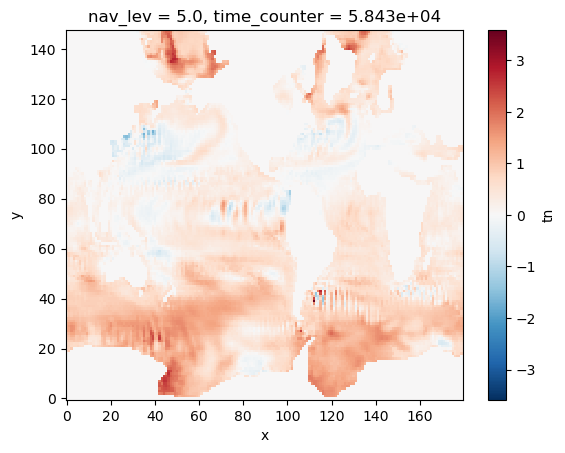

In [12]:
delta = rdata['tn'].isel(time_counter=0,nav_lev=0) - fdata['tn'].isel(time_counter=0,nav_lev=0)
delta.plot()

In [6]:
tstep = float(os.path.basename(glob.glob(filename)[0]).split('_')[1])

In [35]:
tstep

58432.0

In [7]:
#field = xr.where(rdata['tn']>0, 1, 0)
#field.isel(time_counter=0,nav_lev=0).plot()

In [8]:
#cdo.merge_rebuilt(expname, startleg, endleg)

In [9]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True)
field = pattern.isel(time_counter=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True)
    p = timeseries.polyfit(dim='time_counter', deg=1, skipna = True)
    # theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    theta = timeseries[var].isel(time_counter=-1)
    laststep = pattern.isel(time_counter=i)
    field = field + theta.isel(lat=0,lon=0,zaxis_Reduced=0)*laststep
field = field.drop_vars({'time_counter','lon','lat','zaxis_Reduced'})

In [16]:
filename=os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_product.nc")
field.to_netcdf(filename, mode='w')

In [48]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_forecast.nc")
field = xr.open_mfdataset(filename, use_cftime=True)
field

<xarray.Dataset> Size: 7MB
Dimensions:  (nav_lev: 31, y: 148, x: 180)
Coordinates:
  * nav_lev  (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn       (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jul 02 08:35:23 2024: cdo add tn_product.nc -timmean tn...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

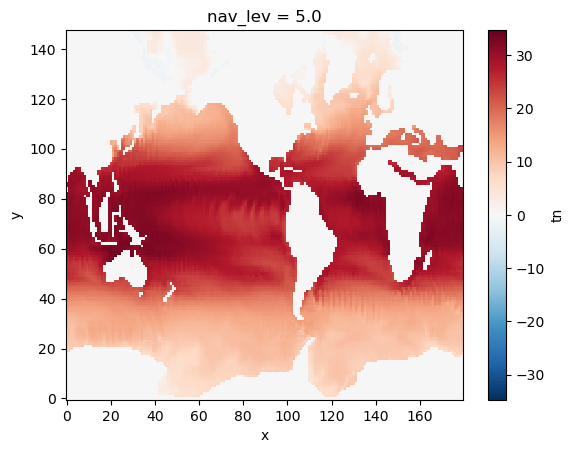

In [18]:
field['tn'].isel(nav_lev=0).plot()

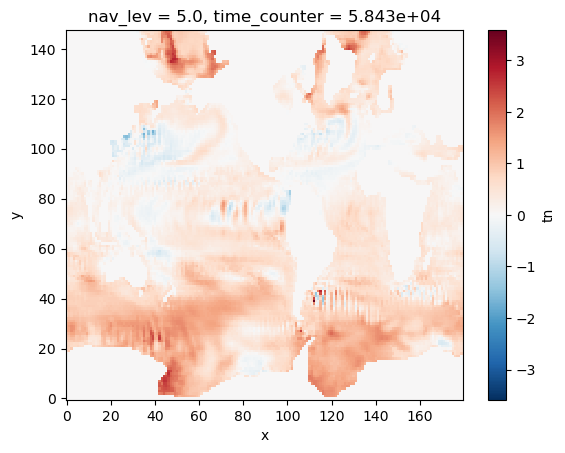

In [9]:
delta = rdata['tn'].isel(time_counter=0,nav_lev=0) - fdata['tn'].isel(time_counter=0,nav_lev=0)
delta.plot() 

In [10]:
df = elements(expname)

In [11]:
rpa = fdata[var].isel(time_counter=0).weighted(df['S']).mean(dim=['y', 'x'])
fpa = rdata[var].isel(time_counter=0).weighted(df['S']).mean(dim=['y', 'x'])

(5, 5000)

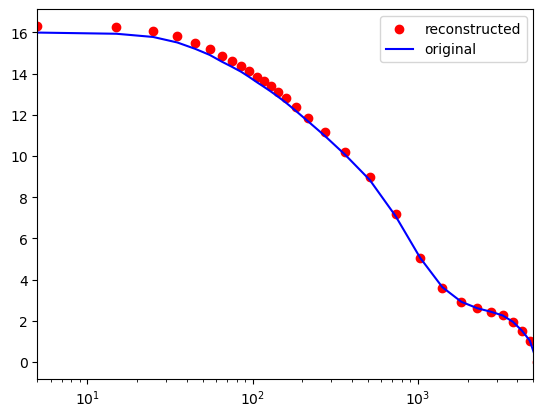

In [15]:
plt.scatter(fpa['nav_lev'].values,fpa.values, color='r', label='reconstructed')
plt.plot(rpa['nav_lev'].values,rpa.values, color='b', label='original')
plt.legend(loc="upper right")
plt.xscale('log')
plt.xlim(5,5000)

(0.0, 5000.0)

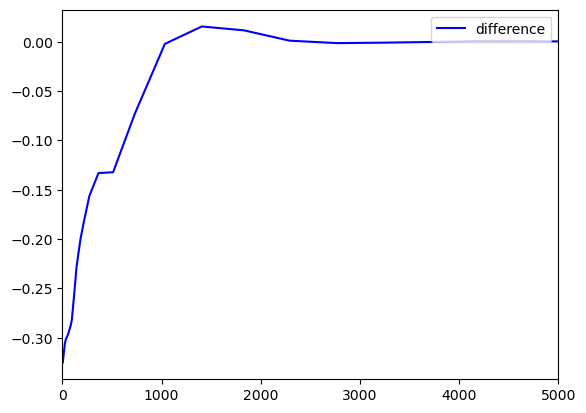

In [13]:
#plt.scatter(fpa['nav_lev'].values,fpa.values, color='r', label='reconstructed')
plt.plot(rpa['nav_lev'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlim(0,5000)

In [41]:
field

<xarray.Dataset> Size: 7MB
Dimensions:  (nav_lev: 31, y: 148, x: 180)
Coordinates:
  * nav_lev  (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn       (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jul 02 08:35:23 2024: cdo add tn_product.nc -timmean tn...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [49]:
field = field.expand_dims({'time_counter': 1})
field['time_counter'] = rdata['time_counter']
rdata[var] = field[var]
filename=os.path.join(dirs['tmp'], str(endleg).zfill(3), "restart.nc")
rdata.to_netcdf(filename, mode='w', unlimited_dims={'time_counter': True}) 